**Bu notebook, Sahte Haber Tespiti Bitirme Projesinin esas kodlarının yer aldığı kısımdır. Modellerin test skorları ve Derin öğrenme modeli için ayrı 2 notebook daha oluşturulmuştur.**

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn import metrics

**Verinin yüklenmesi ve Veri setinin oluşturulması**

In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/Fake.csv")
real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/True.csv")

Gerçek içerikli haberlere 1, Sahte içerikli haberlere 0 etiketi atandı.

In [ ]:
real['label'] = 1
fake['label'] = 0

Veri setindeki gerçek haber metinlerinin öncesinde haberin kaynağının bulunduğu gözlemlendi. Bu modelin yanılmasına sebep olabileceği gerekçesiyle kaldırıldı.

In [ ]:
real.text.head(3)

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
2    WASHINGTON (Reuters) - The special counsel inv...
Name: text, dtype: object

In [ ]:
# remove prepended source from real news
cleantext = []

for item in real["text"]:
    text = item.partition(" - ")
    cleantext.append(text[2])
real["text"] = cleantext
#---

Gerçek ve sahte içerikli haberler birleştirilip karılarak tek dataframe oluşturuldu.

In [ ]:
df = pd.concat([real,fake])
df = df.sample(frac = 1, random_state=1) # SAMPLE SIZE



---



**Keşifsel Veri Analizi (EDA)**

In [ ]:
print('Sütunlar: ',df.columns)

Sütunlar:  Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [ ]:
df.count()

title      44898
text       44898
subject    44898
date       44898
label      44898
dtype: int64

In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
df.head()

,title,text,subject,date,label
4528,EPA chief says Paris climate agreement 'bad de...,The United States should continue to be “engag...,politicsNews,"April 2, 2017",1
10310,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,"Jul 26, 2017",0
10937,Trump says New Hampshire win not necessary to ...,U.S. Republican presidential candidate Donald ...,politicsNews,"February 7, 2016",1
13470,Kremlin: U.S. sanctions aimed at turning busin...,The Kremlin said on Thursday it was confident ...,worldnews,"November 30, 2017",1
19397,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,"Dec 27, 2016",0


Dataframedeki gerçek ve sahte haber sayılarının dağılımı

0    23481
1    21417
Name: label, dtype: int64

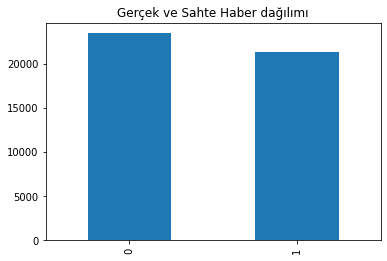

In [ ]:
# plot news label count
df['label'].value_counts().plot(kind='bar',title='Gerçek ve Sahte Haber dağılımı')
df.label.value_counts()



*   Veri setinde Başlık, Haber metni, Haber konusu, Tarih ve tahmin için eklenen etiketten oluşan 5 sütun olduğu görülüyor.
*   Toplam haber 44 bin haber olduğu, Sahte ve Gerçek haber veri sayılarının dengeli olduğu görülüyor.
* Veri setinde eksik girdi bulunmadığı görülüyor.






---



Gerçek ve sahte haberlerdeki kelimelerin kullanılma sıklığına göre Kelime Bulutu(word cloud) oluşturulması

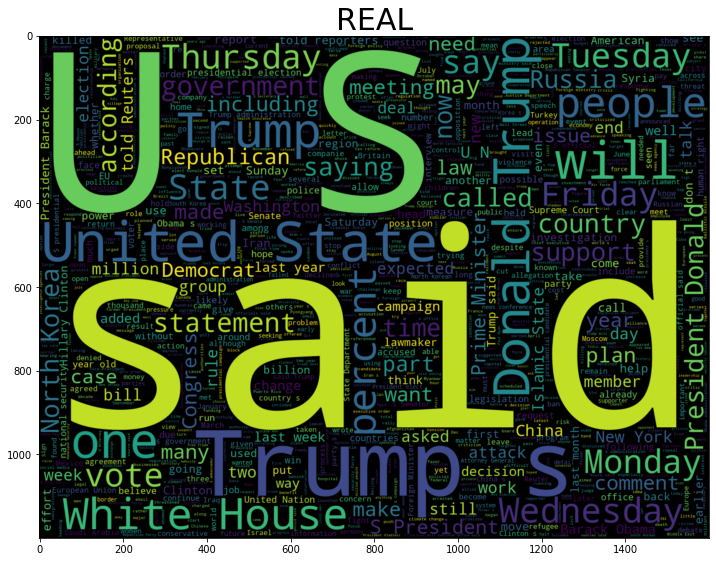

In [ ]:
# Gerçek haberler Kelime Bulutu

plt.figure(figsize = (12,12))
wc_real = WordCloud(max_words = 1000 , width = 1600 , height = 1200 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
# dict={'fontsize':30}
plt.title('REAL', {'fontsize':30})
# plt.title()
plt.imshow(wc_real , interpolation = 'bilinear')

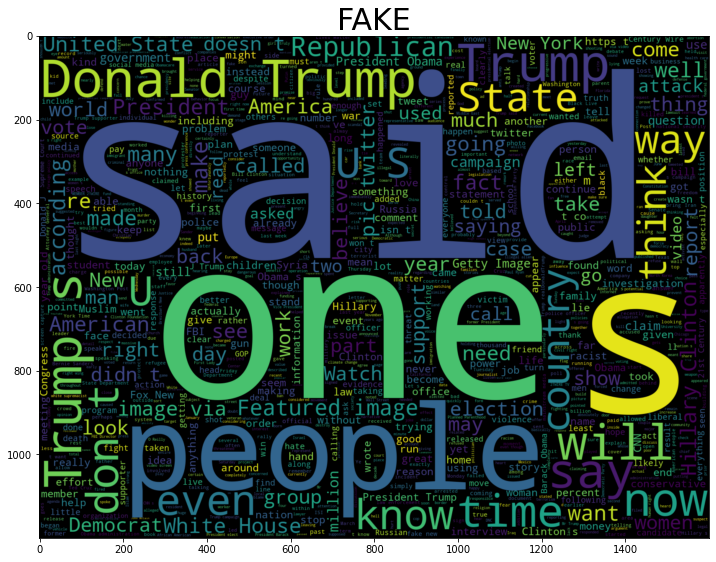

In [ ]:
# Sahte haberler Kelime Bulutu

plt.figure(figsize = (12,12))
wc_fake = WordCloud(max_words = 1000 , width = 1600 , height = 1200 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
dict={'fontsize':30}
plt.title('FAKE', dict)
plt.imshow(wc_fake , interpolation = 'bilinear')

**ÖN İŞLEME (Pre-processing)**

Helper Functions

In [ ]:
#text cleaner
def clean(text):
    text = re.sub('[^a-zA-Z-@]', ' ', text)
    text = text.lower() #küçük harfe çevir
    text = text.split()
    text = ' '.join(text)
    return text

In [ ]:
#stemmer
ps = PorterStemmer()

def stemmer(text):
  text = text.split()
  text = [ps.stem(word) for word in text]
  text = ' '.join(text)
  #text = ps.stem(text)
  return text

In [ ]:
#lemmatizer
nlp = spacy.load('en_core_web_sm')

def lemmatizer(text):
  doc = nlp(text)
  text = ([word.lemma_ for word in doc])
  text = ' '.join(text)
  return text

In [ ]:
#stopword remover
def stopword(text):
    doc = nlp(text)
    clean_text = [token.text for token in doc if not token.is_stop]
    return " ".join(clean_text) #convert array to string



---



In [ ]:
#drop columns
df = df.drop('title', axis=1)
df = df.drop('subject', axis=1)
df = df.drop('date', axis=1)

#regex cleaning and lowercase
df["text"] = df["text"].apply(clean)



In [ ]:
#removing stopwords
df['text'] = df['text'].apply(stopword)

# #stemming
df['stem'] = df['text'].apply(stemmer)

# #lemmatizing
# df['lemma'] = df['text'].apply(lemmatizer)

In [ ]:
#specifying dependent and independent variables
X = df['stem'] #text|stem|lemma
y = df['label']

In [ ]:
df.head()

,text,label,stem
4528,united states continue engaged international c...,1,unit state continu engag intern climat chang d...
10310,president trump tweeted new policy military co...,0,presid trump tweet new polici militari consult...
10937,u s republican presidential candidate donald t...,1,u s republican presidenti candid donald trump ...
13470,kremlin said thursday confident united states ...,1,kremlin said thursday confid unit state sancti...
19397,kellyanne conway s response williams criticism...,0,kellyann conway s respons william critic ve co...


**VEKTÖRLEŞTİRME**

Metin verilerinin TF-IDF yöntemi kullanılarak vektörler ile ifade edilmesi.

In [ ]:
#transform X to matrix
vectorize = TfidfVectorizer()
Xv = vectorize.fit_transform(X)

In [ ]:
# Xv matrisinin boyutu
Xv.shape

(44898, 89526)

**MODEL OLUŞTURMA**

KNN model

k-Nearest Neighbors algoritmasında uygun komşu sayısının seçilmesi için farklı k değerleriyle denemeler yapılıp doğruluk grafiğinin oluşturulması

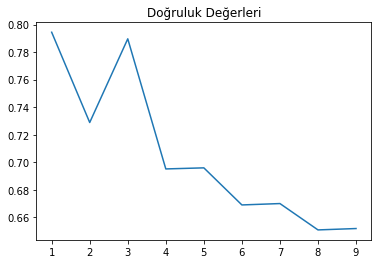

In [ ]:
# KNN GridSearch

Xv_train, Xv_test, y_train, y_test = train_test_split(Xv, y, test_size = 0.2, random_state=1)

k_range = list(range(1, 10))
scores = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(Xv_train, y_train)
    y_pred = knn.predict(Xv_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, scores)
plt.title('Doğruluk Değerleri')
plt.show()

Optimum k değerinin 1 olduğu görülüyor.

In [ ]:
# KNN modelin 5-kat çapraz doğrulama ile eğitimi ve doğruluk değerleri
knn = KNeighborsClassifier(n_neighbors=1)
cv_scores = cross_val_score(knn, Xv, y, cv=5) 

#print each cv score(accuracy) and average
print('Doğruluk değerleri: ',cv_scores)
print('Ortalama: {}'.format(np.mean(cv_scores)))

Doğruluk değerleri:  [0.79977728 0.80167038 0.8018931  0.79485466 0.79474329]
Ortalama:0.7985877416024671


Bayes Model

In [ ]:
# Multinomial Naive Bayes modelin 5-kat çapraz doğrulama ile eğitimi ve doğruluk değerleri
mnb = MultinomialNB()
cv_scores = cross_val_score(mnb, Xv, y, cv=5)

#print each cv score(accuracy) and average
print('Doğruluk değerleri: ',cv_scores)
print('Ortalama: {}'.format(np.mean(cv_scores)))

Doğruluk değerleri:  [0.92572383 0.92639198 0.92973274 0.92694064 0.9217062 ]
Ortalama: 0.926099078994268


Logistic Regression Model

In [ ]:
# Logistic Regression modelinin 5-kat çapraz doğrulama ile eğitimi ve doğruluk değerleri
lr = LogisticRegression()
cv_scores = cross_val_score(lr, Xv, y, cv=5)

#print each cv score(accuracy) and average
print('Doğruluk değerleri: ',cv_scores)
print('Ortalama: {}'.format(np.mean(cv_scores)))

Doğruluk değerleri:  [0.97639198 0.97282851 0.97951002 0.97716895 0.97438468]
Ortalama: 0.976056827474947
